In [1]:
import sys
sys.path.append('/home/royhirsch_google_com/image_editing')

import os
import pickle
from tqdm import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import json
import torch
from functools import partial
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler, DPMSolverMultistepScheduler


In [2]:
# /home/royhirsch_google_com/image_editing/files/xl/coco_828781
sample_name = 'drawbench_64'
device = torch.device('cuda:1')
model_name = 'xl'
image_dir = f'/home/royhirsch_google_com/image_editing/files/{model_name}/{sample_name}'
torch_dtype = torch.float16


def get_all_abs_filenames(dir_name):
    return [os.path.join(dir_name, f) for f in os.listdir(dir_name)]

with open('/home/royhirsch_google_com/image_editing/sample_qa.json', 'r') as f:
    qa = json.load(f)

for sample in qa:
    if sample['id'] == sample_name:
        break

questions = sample['questions']
prompt = sample['prompt']

pickle_image_paths = get_all_abs_filenames(image_dir)

# Load samples and VQScores


In [3]:
sys.path.append('/home/royhirsch_google_com/t2v_metrics')
import t2v_metrics
from PIL import Image
import os


clip_flant5_score = t2v_metrics.VQAScore(model='clip-flant5-xxl') # our recommended scoring model


def save_images(image_list, output_dir, base_filename="image", format="PNG"):

    if not image_list:
        raise ValueError("The image list is empty. Please provide a list of images to save.")

    os.makedirs(output_dir, exist_ok=True)

    file_names = []
    for idx, image in tqdm(enumerate(image_list)):

        filename = f"{base_filename}_{idx + 1}.{format.lower()}"
        filepath = os.path.join(output_dir, filename)
        
        if image.ndim == 2:  # Grayscale
            pil_image = Image.fromarray((image * 255).astype(np.uint8))  # Scale if needed
        elif image.ndim == 3 and image.shape[2] in [3, 4]:  # RGB or RGBA
            pil_image = Image.fromarray((image * 255).astype(np.uint8))
        else:
            raise ValueError(f"Image at index {idx} must be 2D (grayscale) or 3D (RGB/RGBA).")

        pil_image.save(filepath, format=format)
        file_names.append(filepath)
    return file_names

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
sample_source_vqa_scores_file = os.path.join(image_dir, f'{sample_name}_vqa_scores.pickle')

if not os.path.exists(sample_source_vqa_scores_file):
    all_results = []
    seed2score = {}
    for path in pickle_image_paths:
        with open(path, 'rb') as f:
            pickle_data = pickle.load(f)

        if 'results' in pickle_data:
            print(f'Loaded {path}')
            image_list=[item['image'] for item in pickle_data['results']]
            image_paths = save_images(image_list=image_list,
                                        output_dir="saved_images",
                                        base_filename="example_image",
                                        format="PNG")
            texts = [prompt]
            scores = clip_flant5_score(images=image_paths, texts=texts).flatten()
            print('Calculated VQAScores')
            for item, score in zip(pickle_data['results'], scores):
                item['score'] = score
                all_results.append(item)
                seed2score[item['seed']] = score

        with open(sample_source_vqa_scores_file, 'wb') as f:
            pickle.dump(
                {
                    'seed2score': seed2score,
                    'questions': questions,
                    'prompt': prompt,
                },
                f)
        print(f'Saved VQA scores to {sample_source_vqa_scores_file}')

else:
    with open(sample_source_vqa_scores_file, 'rb') as f:
        seed2score = pickle.load(f)['seed2score']
    print(f'Loaded VQA scores from {sample_source_vqa_scores_file}')
    
    all_results = []
    for path in pickle_image_paths:
        with open(path, 'rb') as f:
            pickle_data = pickle.load(f)
        if 'results' in pickle_data:
            all_results += pickle_data['results']

    for item in all_results:
        item['score'] = seed2score[item['seed']]

n_items = len(np.unique(np.array([item['seed'] for item in all_results])))
print(f'Loaded {n_items} unique items')


Loaded /home/royhirsch_google_com/image_editing/files/xl/drawbench_64/SDxl_drawbench_64_4.pickle


25it [00:09,  2.50it/s]


Calculated VQAScores
Saved VQA scores to /home/royhirsch_google_com/image_editing/files/xl/drawbench_64/drawbench_64_vqa_scores.pickle
Loaded /home/royhirsch_google_com/image_editing/files/xl/drawbench_64/SDxl_drawbench_64_3.pickle


25it [00:09,  2.55it/s]


Calculated VQAScores
Saved VQA scores to /home/royhirsch_google_com/image_editing/files/xl/drawbench_64/drawbench_64_vqa_scores.pickle


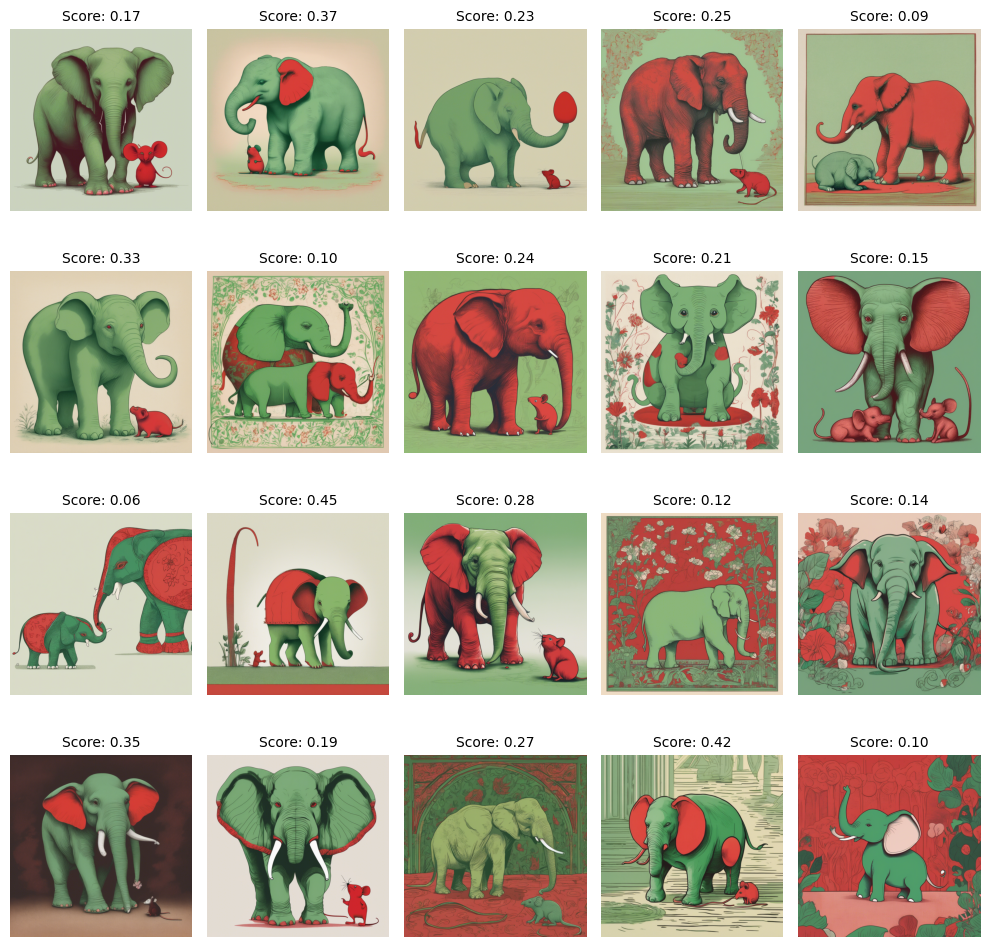

An illustration of a small green elephant standing behind a large red mouse.


In [8]:
def plot_images_with_scores(image_list, scores, grid_shape=None, figsize=(10, 10), cmap=None):
    if len(image_list) != len(scores):
        raise ValueError("The number of images and scores must be the same.")
    
    # Determine the grid shape automatically if not provided
    if grid_shape is None:
        cols = int(np.ceil(np.sqrt(len(image_list))))
        rows = int(np.ceil(len(image_list) / cols))
    else:
        rows, cols = grid_shape

    # Create the figure
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()  # Flatten axes for easier iteration

    for idx, (image, score) in enumerate(zip(image_list, scores)):
        ax = axes[idx]
        # Plot the image
        if image.ndim == 2:  # Grayscale image
            ax.imshow(image, cmap=cmap or "gray")
        elif image.ndim == 3:  # Color image
            ax.imshow(image)
        else:
            raise ValueError(f"Image at index {idx} must be 2D (grayscale) or 3D (color).")

        # Display the score as the title
        ax.set_title(f"Score: {score:.2f}", fontsize=10)
        ax.axis("off")  # Hide axes

    # Turn off any unused subplots
    for ax in axes[len(image_list):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


image_list = [item['image'] for item in all_results[50:70]]
scores = [item['score'] for item in all_results[50:70]]
plot_images_with_scores(image_list, scores, grid_shape=None, figsize=(10, 10), cmap=None)
print(prompt)

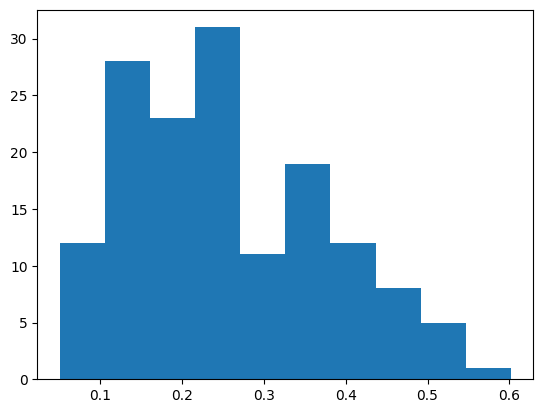

In [9]:
num_samples = len(all_results)
_ = plt.hist([item['score'].item() for item in all_results])

# Calc moving vectors

In [15]:
# results['results'] is a list of dicts
# the key 'h_space' is a dict, each entry is a list of tensors

layer_name = 'down_zero'

# seed2h_space Dict[int, List[torch.tensor]]
seed2image = {}
seed2h_space = {}
seed2score = {}
for item in all_results[:num_samples]:
    h_space = item['h_space'][layer_name]
    seed2h_space[item['seed']] = h_space
    seed2image[item['seed']] = item['image']
    seed2score[item['seed']] = item['score']

###### weighted mean ######
scores = torch.tensor(list(seed2score.values()))
move_vectors = []
for i in range(len(seed2h_space[item['seed']])):
    h_space = [item[i] for item in seed2h_space.values()]
    data_tensor = torch.stack(h_space)  # Shape: (N, H, W, C)
    weights = scores / scores.sum()
    weights = weights.view(-1, 1, 1, 1, 1)  # Shape: (N, 1, 1, 1)
    
    # norm each h_space element
    tensor_flattened = data_tensor.view(150, -1)
    norms = torch.norm(tensor_flattened, dim=1, keepdim=True) + 1e-12
    norms = norms.view(150, 1, 1, 1, 1)
    data_tensor = data_tensor / norms
    #
    
    weighted_mean = torch.sum(data_tensor * weights, dim=0)  # Shape: (H, W, C)
    move_vectors.append(weighted_mean)

###### threhsold ######
# thresh = 0.3
# pos_examples = [h_space for ind, h_space in seed2h_space.items() if seed2score[ind] >= thresh]
# neg_examples = [h_space for ind, h_space in seed2h_space.items() if seed2score[ind] < thresh]
# print('Num pos: {} Num neg: {}'.format(len(pos_examples), len(neg_examples)))


# def get_average_list(h_space_list):
#     num_steps = len(h_space_list[0])
#     mean_latents = []
#     for i in range(num_steps):
#         mean_latents.append(torch.stack([item[i].detach().cpu() for item in h_space_list]).mean(0))
#     return mean_latents


# pos_mid  = get_average_list(pos_examples)
# neg_mid  = get_average_list(neg_examples)
# print('Num moving tensor (denoising steps): {}\nShape of a single moving tensor: {}'.format(len(pos_mid), pos_mid[0].shape))
# print('\nNum moving tensor (denoising steps): {}\nShape of a single moving tensor: {}'.format(len(neg_mid), neg_mid[0].shape))

# move_vectors = [p - n for p, n in zip(pos_mid, neg_mid)]
# rand_move_vectors = [torch.rand_like(item) for item in move_vectors]

In [16]:
from sd_utils import get_sd_pipe, _GENERATION_CONFIGS

pipe = get_sd_pipe(model_name, device, torch_dtype)
config = _GENERATION_CONFIGS[model_name]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [1]:
# 1, 20, 517
factors = [0, 1e3, 1.2e3]
seed = 136
calc_tifa  = False

start_modify = 0
stop_modify = 50

def modify_down_h_space(module, input, output, factor, step=[0]):
    if step[0] >= start_modify and step[0] <= stop_modify:
        sample = output[0]
        change = factor * move_vectors[step[0]].to(sample.device)
        step[0] += 1
        sample += change
        return tuple([sample] + list(output[1:]))
    else:
        step[0] += 1
        return output
        
def modify_mid_h_space(module, input, output, factor, step=[0]):
    change = factor * move_vectors[step[0]].to(output.device)
    step[0] += 1
    return output + change

modify_h_space_func = modify_down_h_space if 'down' in layer_name else modify_mid_h_space

fig, axes = plt.subplots(1, len(factors), figsize=(len(factors) * 5, 10)) 
with torch.no_grad():
    for ind, factor in enumerate(factors):
        if 'down' in layer_name:
            num = {'zero': 0, 'one': 1, 'two': 2, 'three': 3}[layer_name.split('_')[1]]
            hook = pipe.unet.down_blocks[num].register_forward_hook(
                partial(modify_h_space_func, factor=factor, step=[0]))
        else:
            hook = pipe.unet.mid_block.register_forward_hook(
                partial(modify_h_space_func, factor=factor, step=[0]))
            
        generator = torch.Generator(device=device).manual_seed(seed)
        image = pipe(prompt, generator=generator, **config).images[0]
        hook.remove()
        
        axes[ind].imshow(image)
        if calc_tifa:
            score = None
            axes[ind].set_title('Factor: {} Tifa: {:.3f}'.format(factor, score))
        else:
            
            axes[ind].set_title('Factor: {}'.format(factor))
        axes[ind].axis('off')

plt.show()

NameError: name 'layer_name' is not defined